In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print("Current working directory:", os.getcwd())
print("Added to sys.path:", src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap

Current working directory: /Users/sammysharief/Downloads/Pokie/notebook
Added to sys.path: /Users/sammysharief/Downloads/Pokie/src


# Sample from GMM

In [2]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 76.74it/s]


Final Models Shape: (21, 500, 500, 2)
Truth Data Shape: (500, 2)
Shape validation passed!
Truth Data Normalized:
Min: [0. 0.]
Max: [1. 1.]

Models Normalized (Overall):
Min: -0.9606958541978782
Max: 1.9484755346507632

Model 0 (Shift -10):
Min: -0.9606958541978782
Max: 0.1374719605148382

Model 1 (Shift -9):
Min: -0.8186404616577411
Max: 0.2536608875396122

Model 2 (Shift -8):
Min: -0.7057838462854038
Max: 0.4068110642594977

Model 3 (Shift -7):
Min: -0.649267204913167
Max: 0.41689322871078244

Model 4 (Shift -6):
Min: -0.5261267570363406
Max: 0.5525561821035424

Model 5 (Shift -5):
Min: -0.4943801912340676
Max: 0.5760573274701308

Model 6 (Shift -4):
Min: -0.3776911882875372
Max: 0.7132206587222705

Model 7 (Shift -3):
Min: -0.26910689582949376
Max: 0.7625846907930794

Model 8 (Shift -2):
Min: -0.2158278250437918
Max: 0.8362259682508484

Model 9 (Shift -1):
Min: -0.09375878164438016
Max: 0.931202139863314

Model 10 (Shift 0):
Min: -0.06680972779740181
Max: 1.047486771669327

Model 11 

100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Results: [0.04245286 0.04400412 0.04459877 0.04623143 0.04718435 0.0488019
 0.05011444 0.05102666 0.05215144 0.05278251 0.05298105 0.05288748
 0.05224594 0.05052456 0.04950959 0.04776188 0.04517838 0.04402249
 0.04284187 0.04163738 0.04106088]


Calibrated: [0.53378928 0.55329444 0.56077128 0.58129992 0.59328164 0.61362024
 0.63012372 0.64159368 0.65573632 0.66367112 0.66616752 0.66499104
 0.65692456 0.63528044 0.62251852 0.60054336 0.5680592  0.55352532
 0.5386806  0.52353568 0.51628704]
Best Model Index: 10


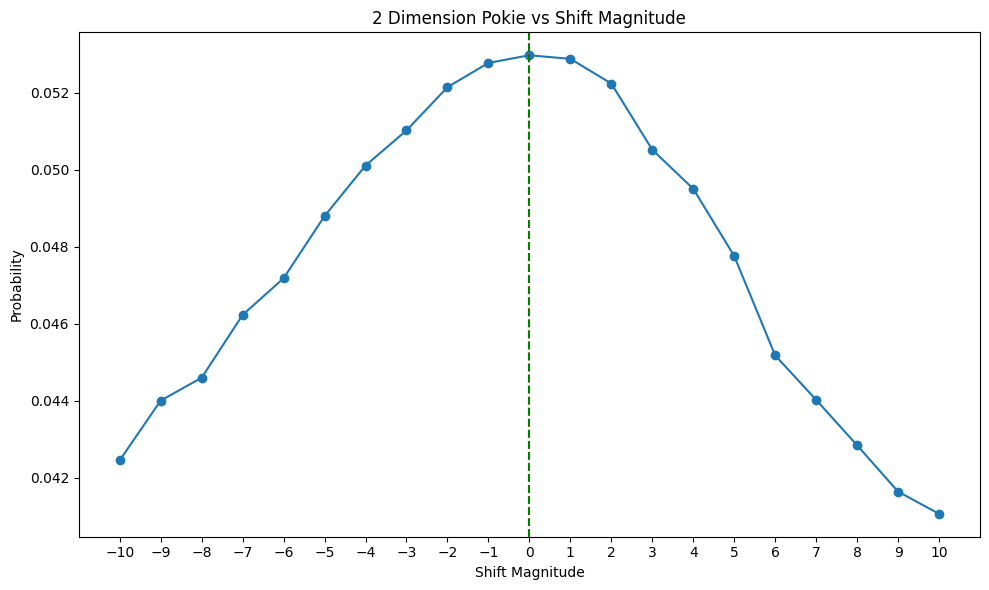

In [3]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)
print('\n')
print('Calibrated:', calibrated)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/2D_Pokie_vs_Shift_Magnitude_Normalized.pdf')
plt.show()

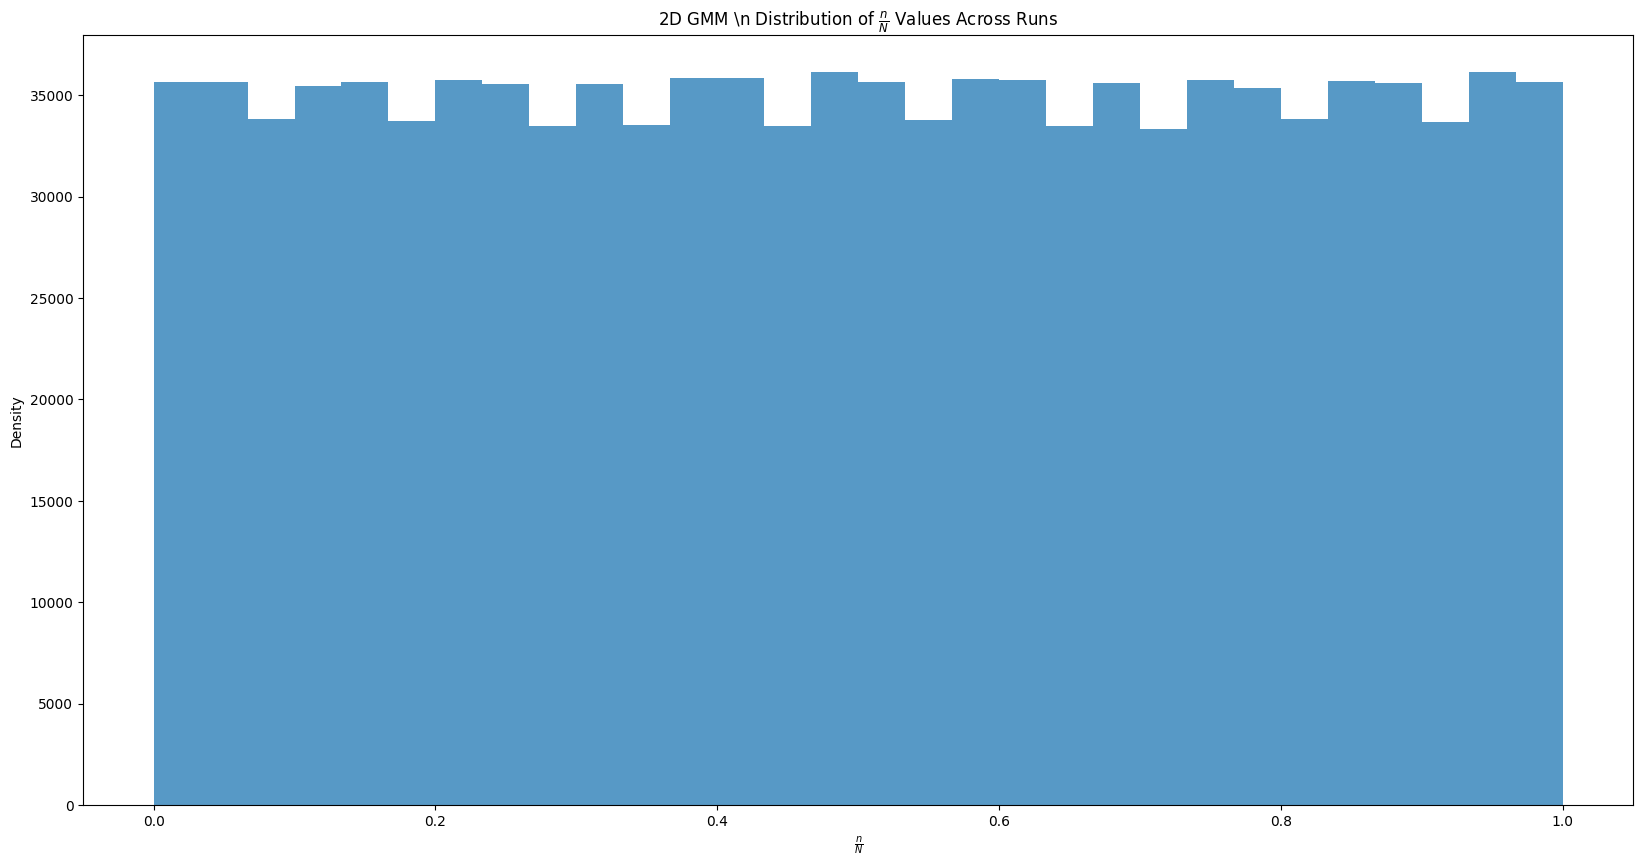

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(n_over_N_vals, bins=30, alpha=0.75)
plt.title(r"2D GMM \n Distribution of $\frac{n}{N}$ Values Across Runs")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.savefig('./Plots/GMM/2D_Pokie_n_over_N_Distribution.pdf')
plt.show()

Individual Model Results: [0.53378928 0.55329444 0.56077128 0.58129992 0.59328164 0.61362024
 0.63012372 0.64159368 0.65573632 0.66367112 0.66616752 0.66499104
 0.65692456 0.63528044 0.62251852 0.60054336 0.5680592  0.55352532
 0.5386806  0.52353568 0.51628704]
Best Model Index: 10


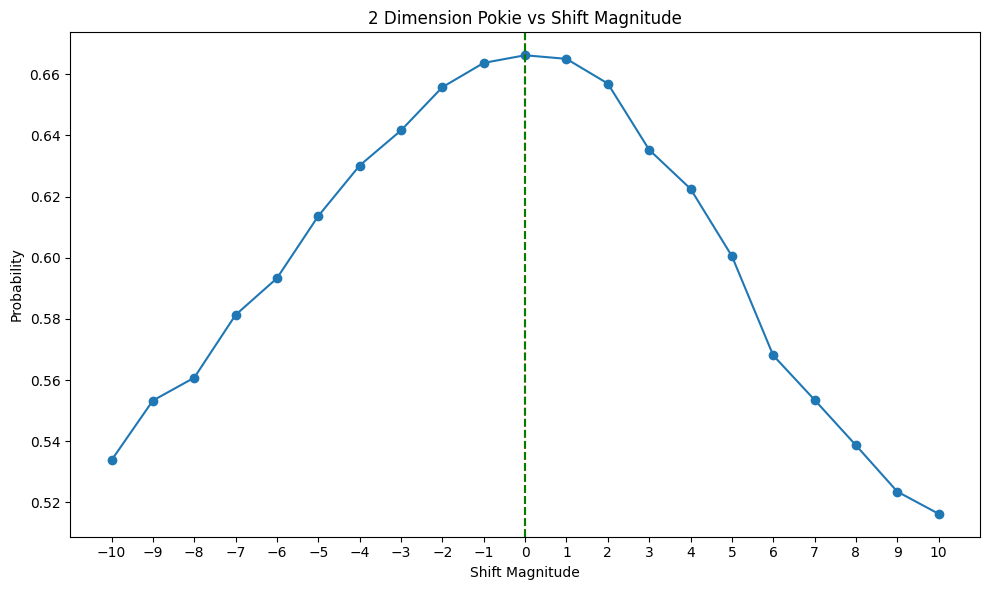

In [5]:
print(f'Individual Model Results: {calibrated}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(calibrated)
best_model_value = calibrated[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/2D_Pokie_vs_Shift_Magnitude_UnNormalized.pdf')
plt.show()

# 20 Dimensions

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 65.24it/s]


Final Models Shape: (21, 500, 500, 10)
Truth Data Shape: (500, 10)
Shape validation passed!
Truth Data Normalized:
Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Models Normalized (Overall):
Min: -1.016490985280967
Max: 1.991511455004229

Model 0 (Shift -10):
Min: -1.016490985280967
Max: 0.3051485943840021

Model 1 (Shift -9):
Min: -0.9100031442644541
Max: 0.3012792772284886

Model 2 (Shift -8):
Min: -0.7923328021433402
Max: 0.4270430420525811

Model 3 (Shift -7):
Min: -0.799957169781482
Max: 0.5436038532899508

Model 4 (Shift -6):
Min: -0.6175821673505436
Max: 0.5560385110764483

Model 5 (Shift -5):
Min: -0.5566711443396772
Max: 0.6576157849315892

Model 6 (Shift -4):
Min: -0.41508822219150937
Max: 0.782617951674858

Model 7 (Shift -3):
Min: -0.35280848370081647
Max: 0.8029584257374309

Model 8 (Shift -2):
Min: -0.3016342324685389
Max: 0.8807994120763706

Model 9 (Shift -1):
Min: -0.19141002071225616
Max: 1.008252417374613

Model 10 (Shift 0):
Min: -0.05785

100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Results: [0.04235691 0.0424636  0.04272054 0.04279958 0.04391423 0.04586781
 0.04891332 0.05236397 0.05481903 0.05637545 0.05657743 0.05628606
 0.05479009 0.05175569 0.04839805 0.0455279  0.04370607 0.04273671
 0.04262429 0.04259625 0.04240702]
Calibrated: [0.49939532 0.50065316 0.5036826  0.50461452 0.51775636 0.54078944
 0.57669648 0.61738024 0.64632584 0.66467632 0.66705772 0.66362236
 0.64598468 0.6102086  0.57062144 0.53678184 0.51530212 0.5038732
 0.5025478  0.50221712 0.49998612]
Best Model Index: 10
Best Model Index: 10


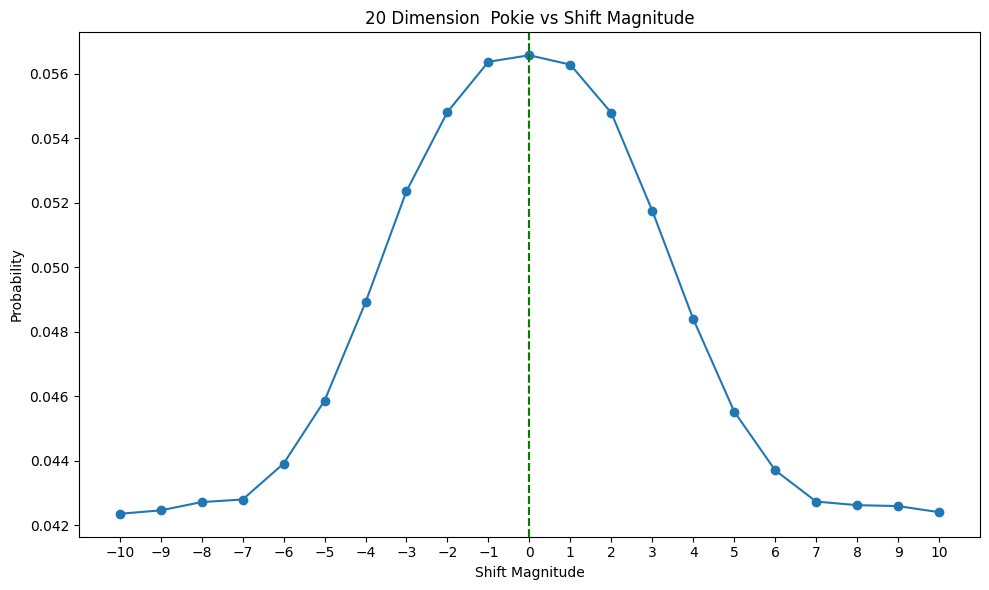

In [9]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)
print('Calibrated:', calibrated)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
print('Best Model Index:', best_model_idx)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('20 Dimension  Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/20D_Pokie_vs_Shift_Magnitude_Normalized.pdf')
plt.show()

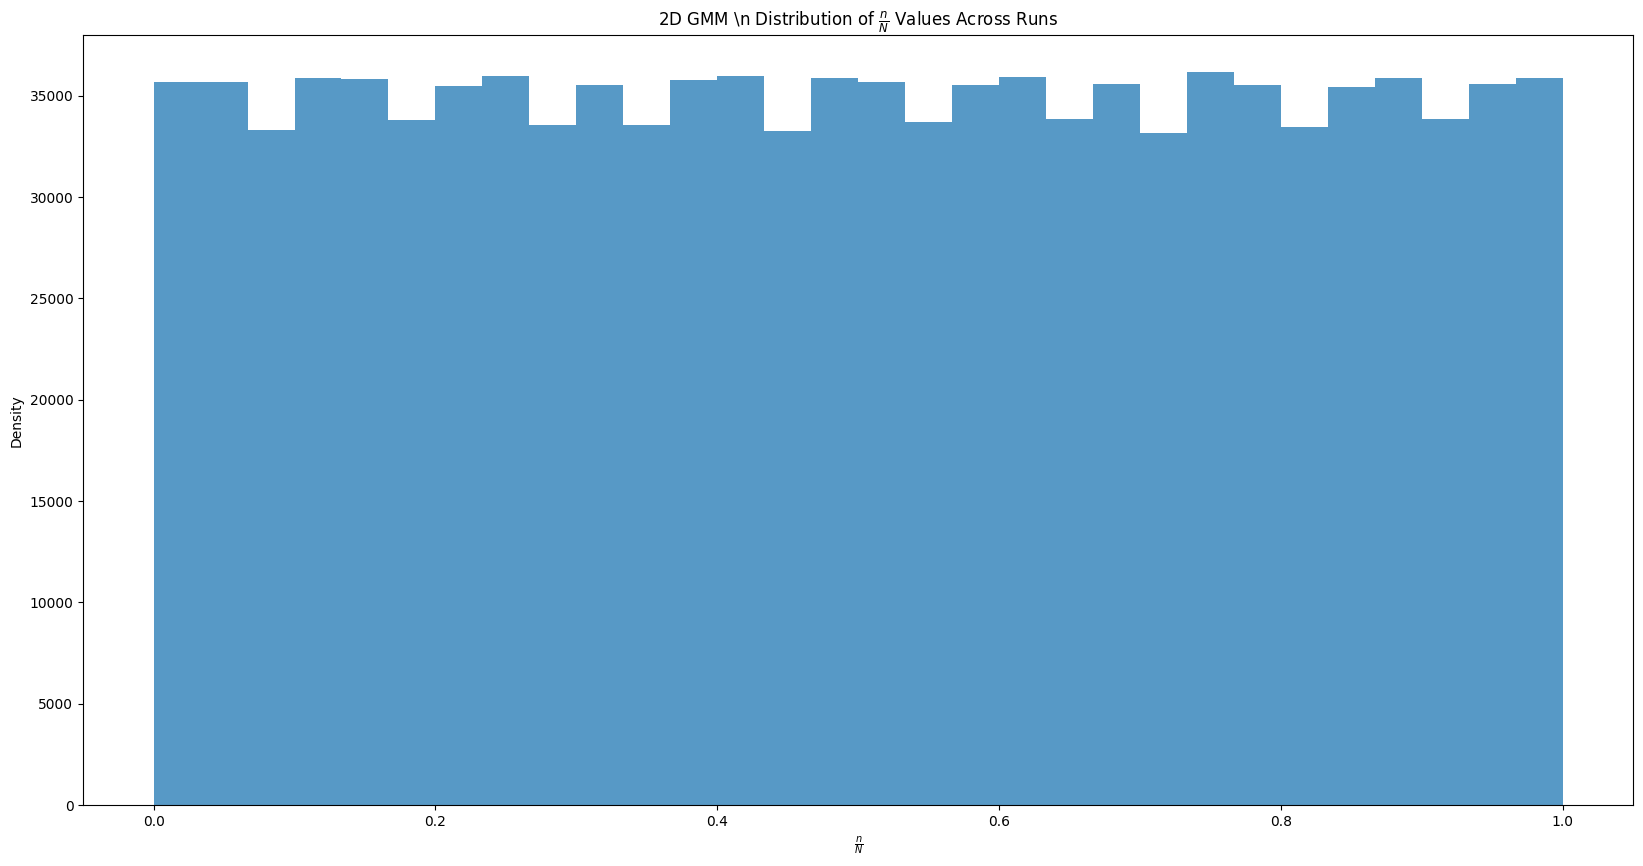

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(n_over_N_vals, bins=30, alpha=0.75)
plt.title(r"2D GMM \n Distribution of $\frac{n}{N}$ Values Across Runs")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.savefig('./Plots/GMM/20D_Pokie_n_over_N_Distribution.pdf')
plt.show()

Individual Model Results: [0.49939532 0.50065316 0.5036826  0.50461452 0.51775636 0.54078944
 0.57669648 0.61738024 0.64632584 0.66467632 0.66705772 0.66362236
 0.64598468 0.6102086  0.57062144 0.53678184 0.51530212 0.5038732
 0.5025478  0.50221712 0.49998612]
Best Model Index: 10


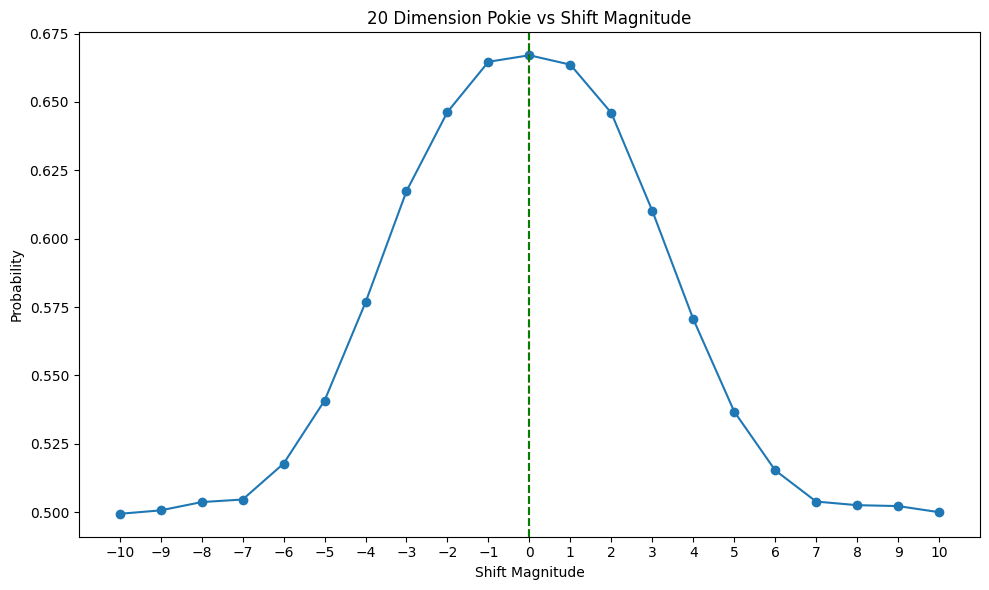

In [11]:
print(f'Individual Model Results: {calibrated}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(calibrated)
best_model_value = calibrated[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('20 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/20D_Pokie_vs_Shift_Magnitude_UnNormalized.pdf')
plt.show()

# 100 Dimension

In [ ]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)
print('Calibrated:', calibrated)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('100 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/100D_Pokie_vs_Shift_Magnitude_Normalized.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(n_over_N_vals, bins=30, alpha=0.75)
plt.title(r"2D GMM \n Distribution of $\frac{n}{N}$ Values Across Runs")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.savefig('./Plots/GMM/100D_Pokie_n_over_N_Distribution.pdf')
plt.show()

In [ ]:
print(f'Individual Model Results: {calibrated}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(calibrated)
best_model_value = calibrated[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('100 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./Plots/GMM/100D_Pokie_vs_Shift_Magnitude_UnNormalized.pdf')
plt.show()